<a href="https://colab.research.google.com/github/enVives/TFG/blob/main/EvaluacioArquitectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import torch
import cv2
import random
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import kagglehub
import pandas as pd
import wandb
import pylab as pl


from glob import glob
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from torchvision import transforms,models
from torch import nn
from torch.utils.data import Dataset
from google.colab import files
from IPython.display import clear_output,display
from google.colab.patches import cv2_imshow
from PIL import Image
from skimage import io

WEIGHTSANDBIASES = True
DOWNLOAD = False
# ORIGEN = '/content/drive/MyDrive/HAM10000/skin-cancer-mnist-ham10000/'

# from google.colab import drive
# drive.mount('/content/drive')

if DOWNLOAD:
  !rm -rf /content/sample_data/*

  !kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

  !unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

#471be466c8949671a46c67e7aad0d5a0ac8c9dad

if WEIGHTSANDBIASES:
  wandb.login()

#torch.cuda.default_stream(torch.device('cuda'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

!rm -rf /content/sample_data/*

!kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

!unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

In [17]:

metadates = pd.read_csv('/content/sample_data/HAM10000_metadata.csv')
metadates = metadates.sort_values(by='image_id')
metadates.head()
print(metadates['dx'].value_counts())
print()
print(metadates['dx'].value_counts() / sum(metadates['dx'].value_counts()))

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

dx
nv       0.669496
mel      0.111133
bkl      0.109735
bcc      0.051323
akiec    0.032651
vasc     0.014179
df       0.011483
Name: count, dtype: float64


nv: melanocytic nevi

vasc: vascular lesions

mel:melanoma

df: dermatofibroma

bkl: benign keratosis-like lesions

bcc: basal cell carcinoma

akiec: Actinic keratoses and intraepithelial carcinoma / Bowen's disease

In [18]:
class Formes(Dataset):
  #Classe on gestionarem les imatges dels fitxers
  dict_illnesses = {0 : 'nv', 1 : 'mel', 2 : 'bkl', 3 : 'bcc', 4 : 'akiec', 5 : 'vasc', 6 : 'df'}

  def __init__(self, images, labels, transform):
        super().__init__()
        self.paths = images
        self.labels = labels
        self.len = len(self.paths)
        self.transform = transform
        #Per defecte pens que el color pot extreure característiques importants, per tant en primer lloc
        #entrenarem les imatges de color
        self.greyscale = False

  def __len__(self):
        return self.len

  def __addlabel__(self,label):
    self.labels = np.append(self.labels,label)

  def __addPath__(self,path):
    self.paths = np.append(self.paths,path)

  def __getdist__(self):
    return pd.Series(self.labels).value_counts()

  def __getlabels__(self):
    classes = [[],[],[],[],[],[],[]]
    for i in range(len(self.labels)):
      classes[self.labels[i]].append(i) #afegim l'index
    return classes

  def __redistribute__(self,percentages):
    #percentages: [15,15,10,10,5,5] percentatges que volem pujar de la resta de classes llevat de nv
    threshold = 0.005  #percentatge de marge que deixam a la redistribució
    Ntarget = self.len
    classes = self.__getlabels__() #indexos de cada clase
    afegir = np.array([0,0,0,0,0,0],dtype=np.int64) # de nv mai haurem d'afegir

    nmel = len(classes[1]) #nombre inicial de cada clase
    nbkl = len(classes[2])
    nbcc = len(classes[3])
    nakiec = len(classes[4])
    nvasc = len(classes[5])
    ndf = len(classes[6])

    while True:

      suma_actual = afegir.sum()

      operacio = percentages[0]*Ntarget - nmel
      afegir[0] +=  operacio if operacio > 0 else 0
      nmel += operacio if operacio > 0 else 0

      operacio = percentages[1]*Ntarget - nbkl
      afegir[1] += operacio if operacio > 0 else 0
      nbkl += operacio if operacio > 0 else 0

      operacio = percentages[2]*Ntarget - nbcc
      afegir[2] += operacio if operacio > 0 else 0
      nbcc += operacio if operacio > 0 else 0

      operacio = percentages[3]*Ntarget - nakiec
      afegir[3] += operacio if operacio > 0 else 0
      nakiec += operacio if operacio > 0 else 0

      operacio = percentages[4]*Ntarget - nvasc
      afegir[4] += operacio if operacio > 0 else 0
      nvasc += operacio if operacio > 0 else 0

      operacio = percentages[5]*Ntarget - ndf
      afegir[5] += operacio if operacio > 0 else 0
      ndf += operacio if operacio > 0 else 0

      if (afegir.sum()-suma_actual) < Ntarget*threshold:
        break

      Ntarget += (afegir.sum()-suma_actual)

    #Quedaria afegir a les imatges les còpies
    for i in range(len(afegir)):
      for j in range(afegir[i]):

          self.__addPath__(self.paths[classes[i+1][random.randint(0, len(classes[i+1]) - 1)]])
          self.__addlabel__(i+1)

    self.len = len(self.labels)

  def __setgreyscale__(self,mode):
    self.greyscale = mode

  def __getitem__(self, index):
      path = self.paths[index]
      label = self.labels[index]

      image = cv2.imread(path, cv2.IMREAD_GRAYSCALE if self.greyscale else cv2.IMREAD_COLOR)

      if self.greyscale:
        image = Image.fromarray(image, mode="L")
      else:
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

      image = self.transform(image)

      return image, label

In [19]:
def calcula_mitjana_desviacio(img_files_path):
  mitjana = np.array([0.0, 0.0, 0.0], dtype=np.float64)
  desviacio = np.array([0.0, 0.0, 0.0], dtype=np.float64)

  x,y = 256,256
  pixels_totals_canal = len(img_files_path) * x * y

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)

    mitjana += np.array([canal_r.sum(), canal_g.sum(), canal_b.sum()])
    #desviacio += np.array([(canal_r**2).sum(), (canal_g**2).sum(), (canal_b**2).sum()])

  mitjana = mitjana / pixels_totals_canal

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)
    desviacio += np.array([((canal_r-mitjana[0])**2).sum(), ((canal_g-mitjana[1])**2).sum(), ((canal_b-mitjana[2])**2).sum()])


  desviacio = np.sqrt(desviacio / pixels_totals_canal)

  return mitjana,desviacio

In [20]:
def load_sets(transformation_training,transformation_default,training_dist,valitation_dist,testing_dist,distribution):

  illnes_dictionary = {
      'nv': 'Melanocytic nevi',
      'mel': 'Melanoma',
      'bkl': 'Benign keratosis-like lesions ',
      'bcc': 'Basal cell carcinoma',
      'akiec': 'Actinic keratoses and intraepithelial carcinoma / Bowens disease',
      'vasc': 'Vascular lesions',
      'df': 'Dermatofibroma'
  }

  img_files_1 = sorted(glob('/content/sample_data/HAM10000_images_part_1/*'))
  img_files_2 = sorted(glob('/content/sample_data/HAM10000_images_part_2/*'))
  img_files = img_files_1 + img_files_2

  img_files = np.array(img_files)


  imgid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in img_files}

  metadates['path'] = metadates['image_id'].map(imgid_path_dict.get)
  metadates['illness'] = metadates['dx'].map(illnes_dictionary.get)
  metadates['illness_code'] = metadates['dx'].map({'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6})

  #Aquest illness_code s'utilitzarà com a label de la enfermetat

  img_number = len(img_files)

  X = metadates.drop('illness_code',axis= 1)
  y = metadates['illness_code']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testing_dist, random_state=42, stratify=y)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=valitation_dist/(training_dist+valitation_dist), random_state=42, stratify=y_train)

  #Una bona idea seria aplicar data augmentation al conjunt d'entrenament ja que les classes estan molt desbalancejades
  #Una altra bona idea seria emplear una funció de pèrdua que tengui en compte les classes desbalancejades.

  #Antes de guardar els datasets en classes Formes, hauriem de caluclar la mitjana i desviació típica de les imatges
  train_data = Formes(X_train['path'].to_numpy(),y_train.to_numpy(),transformation_training)
  test_data = Formes(X_test['path'].to_numpy(),y_test.to_numpy(),transformation_default)
  validation_data = Formes(X_val['path'].to_numpy(),y_val.to_numpy(),transformation_default)


  #prova1: [0.12,0.12,0.06,0.04,0.02,0.02]
  #prova2: [0.12,0.12,0.06,0.04,0.02,0.015]
  #prova3: [0.13,0.13,0.07,0.05,0.02,0.015]

  if distribution != None:
    train_data.__redistribute__(distribution)

  print(train_data.__getdist__())
  print(train_data.len)

  return train_data, test_data,validation_data


In [21]:
def veure_imatges(train_data,std,mean):
  for i in range(len(train_data)):
    imatge,label = train_data.__getitem__(i)

    imatge = imatge * (std[:, None, None]*255) + (mean[:, None, None]*255)

    # Convert the tensor back to a NumPy array
    img_numpy = imatge.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)
    cv2_imshow(img_numpy)
    time.sleep(5)
    clear_output(wait=True)

In [22]:
def get_weights():
  #diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}
  valors = metadates['dx'].value_counts()
  print(valors)
  illnesses = valors.keys()
  weights = np.zeros(len(illnesses))

  i = 0
  for x in illnesses:
    y = valors[x]
    weights[i] = valors.sum() / y
    i+= 1



  weights[1] *= 2.0
  weights[3] *= 2.0
  weights[4] *= 2.0


  weights = weights / weights.sum()


  return (1 - (weights[1]+weights[3]+weights[4])) / (weights[1]+weights[3]+weights[4])

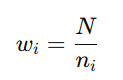

[0.00657042, **0.03958192**, 0.04008614, **0.08570948**, **0.13472377**, 0.31024417,
 0.3830841 ]

 provarem a augmentar en 1.5 els pesos de les enfermetats perilloses:

[0.00581449, 0.05254201, 0.03547423, 0.11377288, 0.17883566, 0.27455052,
 0.33901021]

 i en 2.0:

 [0.00521456, 0.06282768, 0.03181402, 0.13604515, 0.21384468, 0.24622257,
 0.30403135]

 Això pujarà el pes conjunt de les classes perilloses fins a 41%

In [23]:
#veure_imatges(train_data,std,mean)

Ara ja tenim el training preparat. El provarem amb el validation a continuació

##ENTRENAMENT

In [24]:
def tria_model(numero_model,weights):
  if numero_model == 0:
    alexnetbinary = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

    alexnetbinary.classifier = nn.Sequential(
    torch.nn.Linear(9216, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 512),
    nn.ReLU(),
    torch.nn.Linear(512, 1)
    )
    pos_weight = torch.tensor(weights,device = device)
    # print(pos_weight.shape)
    # print(pos_weight)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return alexnetbinary,loss_fn

  elif numero_model == 1:
    resnetbinary = models.resnet50(weights="IMAGENET1K_V1")
    resnetbinary.fc = nn.Linear(in_features=2048, out_features=1)

    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return resnetbinary,loss_fn

  elif numero_model == 2:
    resnetbinary = models.resnet152(weights="IMAGENET1K_V1")
    resnetbinary.fc = nn.Linear(in_features=2048, out_features=1)

    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return resnetbinary,loss_fn

  elif numero_model == 6:
    # alexnetmulticlass = models.alexnet(weights=None)

    # alexnetmulticlass.classifier = nn.Sequential(
    # torch.nn.Linear(9216, 1024),
    # nn.ReLU(),
    # torch.nn.Linear(1024, 1024),
    # nn.ReLU(),
    # torch.nn.Linear(1024, 512),
    # nn.ReLU(),
    # torch.nn.Linear(512, 7),  # Ja que tenim 7 classes.
    # nn.Softmax(dim=1)
    # )
    # loss_fn = nn.CrossEntropyLoss()

    # return alexnetmulticlass,loss_fn
    return




In [25]:
def converteix_a_binari(target):
  #{'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6}
  diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}
  target = ([[str(num.item())] for num in target])

  mapped_tensor = torch.tensor([[diseases[num[0]]] for num in target])
  return mapped_tensor

In [26]:
def train(model,loss_fn,dataloader,optimizer,epoch,device):

  train_acc = 0
  train_f1 = 0
  train_recall = 0
  train_precision = 0
  train_loss = 0

  for batch_num, (input_img, target) in tqdm(enumerate(dataloader), desc=f"Batches (Època {epoch})"):
        model.train()
        optimizer.zero_grad()

        target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
        target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no
        target = target.to(device)


        input_img = input_img.to(device)
        output = model(input_img.to(device))

        loss = loss_fn(output, target.float())

        output = torch.sigmoid(output)

        output = (output.cpu().detach().numpy() > 0.5).astype(int)

        target = target.cpu().detach().numpy()

        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            optimizer.step()

        #print(f"Pèrdua entrenament batch: {batch_num} epoch: {epoch+1}  train_loss: {loss.item()}")
        train_acc += accuracy_score(target,output)
        train_f1 += f1_score(target,output,zero_division=1)
        train_recall += recall_score(target,output,zero_division=1)
        train_precision += precision_score(target,output,zero_division=1)
        train_loss += loss.item()

  return train_acc,train_f1,train_recall,train_precision,train_loss


In [27]:
def validate(model,loss_fn,data_loader,device):
  val_acc = 0
  val_f1 = 0
  val_recall = 0
  val_precision = 0
  val_loss = 0

  model.eval()
  with torch.no_grad():
      for batch_num, (input_img, target) in enumerate(data_loader):
            input_img = input_img.to(device)


            target = torch.unsqueeze(target, 1)
            target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no
            target = target.to(device)

            output = model(input_img)
            loss = loss_fn(output, target.float())

            output = torch.sigmoid(output)
            output = (output.cpu().detach().numpy() > 0.5).astype(int)
            target = target.cpu().detach().numpy()

            val_acc  += accuracy_score(target,output)
            val_f1 += f1_score(target,output,zero_division=1)
            val_recall += recall_score(target,output,zero_division=1)
            val_precision += precision_score(target,output,zero_division=1)

            val_loss += loss.item()

  return val_acc,val_f1,val_recall,val_precision,val_loss

In [28]:
def execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,epochs,device):

  t_loss = np.zeros(epochs)
  v_loss = np.zeros(epochs)
  acc_t = np.zeros(epochs)
  acc_v = np.zeros(epochs)
  f1_t = np.zeros(epochs)
  f1_v = np.zeros(epochs)
  recall_t = np.zeros(epochs)
  recall_v = np.zeros(epochs)
  architecrures_inv = {0: 'alexnet',1:'vgg',2:'resnet'}

  patiente = 100
  best_recall = 0

  pbar = tqdm(range(1, epochs + 1))  # tdqm permet tenir text dinàmic

  for epoch in pbar:

      train_loss = 0
      train_acc = 0
      train_precision = 0
      train_f1 = 0
      train_recall = 0
      val_acc = 0
      val_recall = 0
      val_f1 = 0
      val_loss = 0
      val_precision = 0

      batch_num = 1

      train_acc,train_f1,train_recall,train_precision,train_loss = train(model,loss_fn,train_loader,optimizer,epoch,device)

      val_acc,val_f1,val_recall,val_precision,val_loss  = validate(model,loss_fn,val_loader,device)

      if WEIGHTSANDBIASES:

        training_metrics = {"train/train_loss": train_loss/len(train_loader),
                        "train/train_acc":train_acc/len(train_loader),
                        "train/train_f1":train_f1/len(train_loader),
                        "train/train_recall":train_recall/len(train_loader),
                        "train/train_precision":train_precision/len(train_loader)}

        val_metrics = {"val/val_loss": val_loss/len(val_loader),
                      "val/val_acc":val_acc/len(val_loader),
                      "val/val_f1":val_f1/len(val_loader),
                      "val/val_recall": val_recall/len(val_loader),
                      "val/val_precision": val_precision/len(val_loader)}

        wandb.log({**training_metrics, **val_metrics})

        # torch.save(model, "my_model.pt")
        # wandb.log_model("./my_model.pt", architecrures_inv[MODEL], aliases=[f"epoch-{epoch+1}"])

      # RESULTATS
      train_loss /= len(train_loader)
      train_acc /= len(train_loader)
      train_f1 /= len(train_loader)
      train_recall /= len(train_loader)
      train_precision /= len(train_loader)

      print(f"Pèrdua entrenament epoch: {epoch}  train_loss: {train_loss}")
      print(f"Accuracy train epoch: {epoch}  train_acc: {train_acc}")
      print(f"F1 train epoch: {epoch}  train_f1: {train_f1}")
      print(f"Recall train epoch: {epoch}  train_recall: {train_recall}")

      val_loss /= len(val_loader)
      val_acc /= len(val_loader)
      val_f1 /= len(val_loader)
      val_recall /= len(val_loader)

      print()
      print()
      print(f"Pèrdua validació epoch: {epoch}  val_loss: {val_loss}")
      print(f"Accuracy val epoch: {epoch}  val_acc: {val_acc}")
      print(f"F1 val epoch: {epoch}  val_f1: {val_f1}")
      print(f"Recall val epoch: {epoch}  val_reall: {val_recall}")

      if val_recall > best_recall:
        best_recall = val_recall
        patiente = 100
      else:
        patiente -= 1

      if patiente == 0:
        print("Early Sopping")
        break

  wandb.finish()

In [29]:
from itertools import product
BINARY = True #Si volem que el resultat de la classificació sigui 0 i 1

architectures = {'alexnet': 0,'resnet': 1,'resnet152':2}
MODEL = architectures['resnet152']

TRAINING = 0.75
VALIDATION = 0.15
TESTING = 0.10
SIZE = 224


mean = torch.tensor([194.57463374, 139.13953272, 145.36132088]) /255 #rgb
std = torch.tensor([35.92275236, 38.90347617, 43.33101831]) / 255

TRANSFORMATIONS = []
#FINE_TUNING = [None,models.AlexNet_Weights.IMAGENET1K_V1]
DISTRIBUTIONS = None


transform = transforms.Compose([
    transforms.Resize((SIZE,SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std=std)
])

transform_training = transforms.Compose([
    transforms.Resize((SIZE,SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    #transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    transforms.RandomRotation(degrees=20),
    #transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
    #transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std=std),
])

#load_sets(transformation_training,transformation_default,training_dist,valitation_dist,testing_dist,distribution):

train_data,validation_data,test_data = load_sets(transform_training,transform,TRAINING,VALIDATION,TESTING,DISTRIBUTIONS)

#Realitzar el tuning de hiperparàmetres aquí


EPOCHS = 50
batch_size = 32

#[0.00657042, 0.03958192, 0.04008614, 0.08570948, 0.13472377, 0.31024417, 0.3830841 ]
# WEIGHTS = [[0.00581449, 0.05254201, 0.03547423, 0.11377288, 0.17883566, 0.27455052, 0.33901021],
#  [0.00521456, 0.06282768, 0.03181402, 0.13604515, 0.21384468, 0.24622257, 0.30403135]]

#WEIGHTS = [2.33,1.5]

#get_weights()
WEIGHTS = [get_weights()]

learning_rate  = 1e-4

for weights in product(WEIGHTS):

  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

  model,loss_fn = tria_model(MODEL,weights)


  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  model.to(device)

  projectes = ['Ham10000-AlexnetBinary','Ham1000-ResnetBinary','Ham1000-Resnet152Binary']

  #print(f"{batch_size} , {weights} , {learning_rate}")
  if WEIGHTSANDBIASES:
      wandb.init(
              project=projectes[MODEL],
              config={
                  "epochs": EPOCHS,
                  "batch_size": batch_size,
                  "lr": learning_rate,
                  "trsize":len(train_loader),
                  "trdist":TRAINING,
                  "vsize":len(val_loader),
                  "vdist":VALIDATION,
                  "weights":weights,
                  })
      config = wandb.config
      print(config)

  execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,EPOCHS,device)

0    5028
1     835
2     824
3     386
4     245
5     106
6      86
Name: count, dtype: int64
7510
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:04<00:00, 49.6MB/s]


{'epochs': 50, 'batch_size': 32, 'lr': 0.0001, 'trsize': 235, 'trdist': 0.75, 'vsize': 32, 'vdist': 0.15, 'weights': [1.4229647861576398]}


  0%|          | 0/50 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 1  train_loss: 0.40671473348394355
Accuracy train epoch: 1  train_acc: 0.8372703094777563
F1 train epoch: 1  train_f1: 0.5572795808173985
Recall train epoch: 1  train_recall: 0.5891811734364927


Pèrdua validació epoch: 1  val_loss: 0.4043712392449379
Accuracy val epoch: 1  val_acc: 0.8166015625
F1 val epoch: 1  val_f1: 0.5711409961591892
Recall val epoch: 1  val_reall: 0.7073491612554114


Batches (Època 2): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 2  train_loss: 0.3432552207023539
Accuracy train epoch: 2  train_acc: 0.8764144100580271
F1 train epoch: 2  train_f1: 0.6657135028421508
Recall train epoch: 2  train_recall: 0.6850710518795623


Pèrdua validació epoch: 2  val_loss: 0.3546118070371449
Accuracy val epoch: 2  val_acc: 0.8728515625
F1 val epoch: 2  val_f1: 0.6918901354708243
Recall val epoch: 2  val_reall: 0.7789186507936509


Batches (Època 3): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 3  train_loss: 0.32117303765200556
Accuracy train epoch: 3  train_acc: 0.8807301740812379
F1 train epoch: 3  train_f1: 0.6857868680953457
Recall train epoch: 3  train_recall: 0.7260851559787723


Pèrdua validació epoch: 3  val_loss: 0.3740972587838769
Accuracy val epoch: 3  val_acc: 0.870703125
F1 val epoch: 3  val_f1: 0.5454417883887697
Recall val epoch: 3  val_reall: 0.45974364177489174


Batches (Època 4): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 4  train_loss: 0.296269280035445
Accuracy train epoch: 4  train_acc: 0.8927587040618956
F1 train epoch: 4  train_f1: 0.7079414029974377
Recall train epoch: 4  train_recall: 0.7375966822775333


Pèrdua validació epoch: 4  val_loss: 0.3206128957681358
Accuracy val epoch: 4  val_acc: 0.8833984375
F1 val epoch: 4  val_f1: 0.6852010648450279
Recall val epoch: 4  val_reall: 0.7201107052669553


Batches (Època 5): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 5  train_loss: 0.27436014296526606
Accuracy train epoch: 5  train_acc: 0.9018979690522243
F1 train epoch: 5  train_f1: 0.7351388379897706
Recall train epoch: 5  train_recall: 0.7704844800589482


Pèrdua validació epoch: 5  val_loss: 0.35155359120108187
Accuracy val epoch: 5  val_acc: 0.889453125
F1 val epoch: 5  val_f1: 0.6645004097209982
Recall val epoch: 5  val_reall: 0.6204804743867243


Batches (Època 6): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 6  train_loss: 0.26644734664166225
Accuracy train epoch: 6  train_acc: 0.9063950676982592
F1 train epoch: 6  train_f1: 0.7508464441749467
Recall train epoch: 6  train_recall: 0.7725407571152249


Pèrdua validació epoch: 6  val_loss: 0.30763979628682137
Accuracy val epoch: 6  val_acc: 0.8787109375
F1 val epoch: 6  val_f1: 0.6712807203761151
Recall val epoch: 6  val_reall: 0.7391245039682539


Batches (Època 7): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 7  train_loss: 0.23083365071327128
Accuracy train epoch: 7  train_acc: 0.9196204061895552
F1 train epoch: 7  train_f1: 0.7881786657641056
Recall train epoch: 7  train_recall: 0.8246061149252639


Pèrdua validació epoch: 7  val_loss: 0.35356356971897185
Accuracy val epoch: 7  val_acc: 0.8884765625
F1 val epoch: 7  val_f1: 0.6447222915972916
Recall val epoch: 7  val_reall: 0.5640252976190477


Batches (Època 8): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 8  train_loss: 0.2164789836298912
Accuracy train epoch: 8  train_acc: 0.9246131528046422
F1 train epoch: 8  train_f1: 0.7951674015323658
Recall train epoch: 8  train_recall: 0.8252318367211985


Pèrdua validació epoch: 8  val_loss: 0.42375346133485436
Accuracy val epoch: 8  val_acc: 0.8796875
F1 val epoch: 8  val_f1: 0.6054234674639087
Recall val epoch: 8  val_reall: 0.5190724206349207


Batches (Època 9): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 9  train_loss: 0.20198328483929026
Accuracy train epoch: 9  train_acc: 0.9310565764023211
F1 train epoch: 9  train_f1: 0.8170444987680359
Recall train epoch: 9  train_recall: 0.8472849490934597


Pèrdua validació epoch: 9  val_loss: 0.37909564981237054
Accuracy val epoch: 9  val_acc: 0.8884765625
F1 val epoch: 9  val_f1: 0.6763066590272473
Recall val epoch: 9  val_reall: 0.6726810515873014


Batches (Època 10): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 10  train_loss: 0.19629297511691743
Accuracy train epoch: 10  train_acc: 0.933389748549323
F1 train epoch: 10  train_f1: 0.8187271379785055
Recall train epoch: 10  train_recall: 0.8488195020109915


Pèrdua validació epoch: 10  val_loss: 0.3133322726935148
Accuracy val epoch: 10  val_acc: 0.8884765625
F1 val epoch: 10  val_f1: 0.7011715032903115
Recall val epoch: 10  val_reall: 0.7640252976190477


Batches (Època 11): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 11  train_loss: 0.17825272135595058
Accuracy train epoch: 11  train_acc: 0.9397727272727273
F1 train epoch: 11  train_f1: 0.8306770657999166
Recall train epoch: 11  train_recall: 0.8616398613207121


Pèrdua validació epoch: 11  val_loss: 0.3246776791056618
Accuracy val epoch: 11  val_acc: 0.8876953125
F1 val epoch: 11  val_f1: 0.7106749097243488
Recall val epoch: 11  val_reall: 0.7798363095238097


Batches (Època 12): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 12  train_loss: 0.16972641053193427
Accuracy train epoch: 12  train_acc: 0.9464821083172148
F1 train epoch: 12  train_f1: 0.8536052600438713
Recall train epoch: 12  train_recall: 0.8894409136962327


Pèrdua validació epoch: 12  val_loss: 0.32896334771066904
Accuracy val epoch: 12  val_acc: 0.8876953125
F1 val epoch: 12  val_f1: 0.6979559145919441
Recall val epoch: 12  val_reall: 0.7075994318181819


Batches (Època 13): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 13  train_loss: 0.15708799159273187
Accuracy train epoch: 13  train_acc: 0.9473404255319149
F1 train epoch: 13  train_f1: 0.853077404759413
Recall train epoch: 13  train_recall: 0.8894453773177179


Pèrdua validació epoch: 13  val_loss: 0.37746857199817896
Accuracy val epoch: 13  val_acc: 0.893359375
F1 val epoch: 13  val_f1: 0.6652542906654751
Recall val epoch: 13  val_reall: 0.6682663690476192


Batches (Època 14): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 14  train_loss: 0.14813631659651055
Accuracy train epoch: 14  train_acc: 0.9529376208897485
F1 train epoch: 14  train_f1: 0.8693983922067088
Recall train epoch: 14  train_recall: 0.9043773602284244


Pèrdua validació epoch: 14  val_loss: 0.3101091618882492
Accuracy val epoch: 14  val_acc: 0.8923828125
F1 val epoch: 14  val_f1: 0.6983361074232787
Recall val epoch: 14  val_reall: 0.6882688492063492


Batches (Època 15): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 15  train_loss: 0.13079665247747238
Accuracy train epoch: 15  train_acc: 0.9558027079303676
F1 train epoch: 15  train_f1: 0.8767186313309759
Recall train epoch: 15  train_recall: 0.9131917963832862


Pèrdua validació epoch: 15  val_loss: 0.32600848469883204
Accuracy val epoch: 15  val_acc: 0.90078125
F1 val epoch: 15  val_f1: 0.705536997724498
Recall val epoch: 15  val_reall: 0.6499255952380953


Batches (Època 16): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 16  train_loss: 0.1224178791600973
Accuracy train epoch: 16  train_acc: 0.9607108317214701
F1 train epoch: 16  train_f1: 0.8921868592500655
Recall train epoch: 16  train_recall: 0.9179182401522828


Pèrdua validació epoch: 16  val_loss: 0.3096540617989376
Accuracy val epoch: 16  val_acc: 0.9013671875
F1 val epoch: 16  val_f1: 0.7407483111975223
Recall val epoch: 16  val_reall: 0.7867909000721502


Batches (Època 17): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 17  train_loss: 0.13660457357764244
Accuracy train epoch: 17  train_acc: 0.9559356866537718
F1 train epoch: 17  train_f1: 0.877408361057365
Recall train epoch: 17  train_recall: 0.9119541451456348


Pèrdua validació epoch: 17  val_loss: 0.37684746948070824
Accuracy val epoch: 17  val_acc: 0.893359375
F1 val epoch: 17  val_f1: 0.6427087210175446
Recall val epoch: 17  val_reall: 0.5702313311688311


Batches (Època 18): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 18  train_loss: 0.1050717733522996
Accuracy train epoch: 18  train_acc: 0.9708172147001934
F1 train epoch: 18  train_f1: 0.9188778340598123
Recall train epoch: 18  train_recall: 0.9360526234994322


Pèrdua validació epoch: 18  val_loss: 0.3330864373128861
Accuracy val epoch: 18  val_acc: 0.905078125
F1 val epoch: 18  val_f1: 0.7213091442870857
Recall val epoch: 18  val_reall: 0.721937003968254


Batches (Època 19): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 19  train_loss: 0.10245563151275223
Accuracy train epoch: 19  train_acc: 0.966622340425532
F1 train epoch: 19  train_f1: 0.9095562805174505
Recall train epoch: 19  train_recall: 0.9379120997206106


Pèrdua validació epoch: 19  val_loss: 0.39254087081644684
Accuracy val epoch: 19  val_acc: 0.8970703125
F1 val epoch: 19  val_f1: 0.7121754822727153
Recall val epoch: 19  val_reall: 0.703125


Batches (Època 20): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 20  train_loss: 0.1037774807159254
Accuracy train epoch: 20  train_acc: 0.9668278529980658
F1 train epoch: 20  train_f1: 0.9090103623009609
Recall train epoch: 20  train_recall: 0.9294751466028062


Pèrdua validació epoch: 20  val_loss: 0.3066411158069968
Accuracy val epoch: 20  val_acc: 0.9091796875
F1 val epoch: 20  val_f1: 0.7335460699431289
Recall val epoch: 20  val_reall: 0.7285963168775669


Batches (Època 21): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 21  train_loss: 0.0924525245449486
Accuracy train epoch: 21  train_acc: 0.9707567698259187
F1 train epoch: 21  train_f1: 0.9175352899438611
Recall train epoch: 21  train_recall: 0.947806236316875


Pèrdua validació epoch: 21  val_loss: 0.3159515500301495
Accuracy val epoch: 21  val_acc: 0.903125
F1 val epoch: 21  val_f1: 0.7551281396192387
Recall val epoch: 21  val_reall: 0.7957589285714285


Batches (Època 22): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 22  train_loss: 0.08759206394526235
Accuracy train epoch: 22  train_acc: 0.9718085106382979
F1 train epoch: 22  train_f1: 0.9219356324056996
Recall train epoch: 22  train_recall: 0.9447982868195635


Pèrdua validació epoch: 22  val_loss: 0.35067231752327643
Accuracy val epoch: 22  val_acc: 0.903125
F1 val epoch: 22  val_f1: 0.7486429879352674
Recall val epoch: 22  val_reall: 0.8003844246031747


Batches (Època 23): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 23  train_loss: 0.08575820800095321
Accuracy train epoch: 23  train_acc: 0.972147001934236
F1 train epoch: 23  train_f1: 0.9197023500819724
Recall train epoch: 23  train_recall: 0.9444381505019805


Pèrdua validació epoch: 23  val_loss: 0.39455088740214705
Accuracy val epoch: 23  val_acc: 0.9009765625
F1 val epoch: 23  val_f1: 0.7324086554785086
Recall val epoch: 23  val_reall: 0.7053165584415586


Batches (Època 24): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 24  train_loss: 0.0844903419725597
Accuracy train epoch: 24  train_acc: 0.9724129593810446
F1 train epoch: 24  train_f1: 0.9193706285297752
Recall train epoch: 24  train_recall: 0.9426884935395576


Pèrdua validació epoch: 24  val_loss: 0.3291651897598058
Accuracy val epoch: 24  val_acc: 0.908984375
F1 val epoch: 24  val_f1: 0.7461742398468406
Recall val epoch: 24  val_reall: 0.7381944444444446


Batches (Època 25): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 25  train_loss: 0.08166961950903877
Accuracy train epoch: 25  train_acc: 0.9722920696324953
F1 train epoch: 25  train_f1: 0.9203432321425558
Recall train epoch: 25  train_recall: 0.9498676264633715


Pèrdua validació epoch: 25  val_loss: 0.3901643322315067
Accuracy val epoch: 25  val_acc: 0.9080078125
F1 val epoch: 25  val_f1: 0.7414756159410766
Recall val epoch: 25  val_reall: 0.7408955627705629


Batches (Època 26): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 26  train_loss: 0.06348760380964488
Accuracy train epoch: 26  train_acc: 0.9791223404255319
F1 train epoch: 26  train_f1: 0.941346852457194
Recall train epoch: 26  train_recall: 0.9587760702654322


Pèrdua validació epoch: 26  val_loss: 0.4196387584670447
Accuracy val epoch: 26  val_acc: 0.8916015625
F1 val epoch: 26  val_f1: 0.713139056344842
Recall val epoch: 26  val_reall: 0.7444444444444445


Batches (Època 27): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 27  train_loss: 0.07815144514030915
Accuracy train epoch: 27  train_acc: 0.9768617021276595
F1 train epoch: 27  train_f1: 0.9351414875287822
Recall train epoch: 27  train_recall: 0.9590569477803522


Pèrdua validació epoch: 27  val_loss: 0.361295890645124
Accuracy val epoch: 27  val_acc: 0.890234375
F1 val epoch: 27  val_f1: 0.7166361345389478
Recall val epoch: 27  val_reall: 0.7679439484126986


Batches (Època 28): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 28  train_loss: 0.06163764198984396
Accuracy train epoch: 28  train_acc: 0.981781914893617
F1 train epoch: 28  train_f1: 0.9478159166062814
Recall train epoch: 28  train_recall: 0.9650824352952015


Pèrdua validació epoch: 28  val_loss: 0.45843432343099266
Accuracy val epoch: 28  val_acc: 0.9041015625
F1 val epoch: 28  val_f1: 0.7331500161023187
Recall val epoch: 28  val_reall: 0.7753472222222222


Batches (Època 29): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 29  train_loss: 0.07001010250359616
Accuracy train epoch: 29  train_acc: 0.9778046421663443
F1 train epoch: 29  train_f1: 0.9352635282363232
Recall train epoch: 29  train_recall: 0.9595600380706768


Pèrdua validació epoch: 29  val_loss: 0.44432497513480484
Accuracy val epoch: 29  val_acc: 0.9009765625
F1 val epoch: 29  val_f1: 0.6898541810072005
Recall val epoch: 29  val_reall: 0.748816287878788


Batches (Època 30): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 30  train_loss: 0.061489442621972014
Accuracy train epoch: 30  train_acc: 0.98125
F1 train epoch: 30  train_f1: 0.9452810369838579
Recall train epoch: 30  train_recall: 0.9614805643529047


Pèrdua validació epoch: 30  val_loss: 0.38924895925447345
Accuracy val epoch: 30  val_acc: 0.9041015625
F1 val epoch: 30  val_f1: 0.7446064376477498
Recall val epoch: 30  val_reall: 0.7730992965367964


Batches (Època 31): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 31  train_loss: 0.06674465443047278
Accuracy train epoch: 31  train_acc: 0.9775265957446808
F1 train epoch: 31  train_f1: 0.9361190697993285
Recall train epoch: 31  train_recall: 0.9540921371772437


Pèrdua validació epoch: 31  val_loss: 0.3606933589326218
Accuracy val epoch: 31  val_acc: 0.90703125
F1 val epoch: 31  val_f1: 0.7356849390397185
Recall val epoch: 31  val_reall: 0.7555611922799425


Batches (Època 32): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 32  train_loss: 0.05122679351591208
Accuracy train epoch: 32  train_acc: 0.9838491295938105
F1 train epoch: 32  train_f1: 0.9524863048073984
Recall train epoch: 32  train_recall: 0.9722552270424613


Pèrdua validació epoch: 32  val_loss: 0.3120969026349485
Accuracy val epoch: 32  val_acc: 0.90625
F1 val epoch: 32  val_f1: 0.7547243658478979
Recall val epoch: 32  val_reall: 0.8294700091575091


Batches (Època 33): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 33  train_loss: 0.05523533968730493
Accuracy train epoch: 33  train_acc: 0.9831117021276595
F1 train epoch: 33  train_f1: 0.9526092866568807
Recall train epoch: 33  train_recall: 0.9628764852169108


Pèrdua validació epoch: 33  val_loss: 0.4265005423221737
Accuracy val epoch: 33  val_acc: 0.89296875
F1 val epoch: 33  val_f1: 0.7119382710834916
Recall val epoch: 33  val_reall: 0.7185515873015873


Batches (Època 34): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 34  train_loss: 0.054867491594694076
Accuracy train epoch: 34  train_acc: 0.982313829787234
F1 train epoch: 34  train_f1: 0.9485673002744691
Recall train epoch: 34  train_recall: 0.9648992024523944


Pèrdua validació epoch: 34  val_loss: 0.4696608190133702
Accuracy val epoch: 34  val_acc: 0.900390625
F1 val epoch: 34  val_f1: 0.7472514107624403
Recall val epoch: 34  val_reall: 0.7700520833333335


Batches (Època 35): 0it [00:00, ?it/s]

KeyboardInterrupt: 

In [ ]:
print(training.__len__())